In [1]:
import torch
import torchvision
import numpy as np
from nilearn import plotting
import clinicadl
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import log_loss
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm

/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
from clinicadl.tools.tsv.data_split import create_split
from clinicadl.tools.deep_learning.data import generate_sampler, return_dataset, MRIDataset, MRIDatasetImage, MRIDatasetSlice, get_transforms
from torch.utils.data import DataLoader
from clinicadl.tools.deep_learning.cnn_utils import train, get_criterion, test
from clinicadl.tools.deep_learning.models.random import RandomArchitecture

In [3]:
data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'
df_data = pd.read_csv(data_path,sep='\t',nrows=10)
df_summary = pd.read_csv(summary_path,sep='\t',nrows=10)

In [4]:
input_type = ''
network_type = ''
caps_directory = ''
preprocessing = ''
tsv_path = ''

# Iterator

In [5]:
def fetch_add_data(pipeline_name = 't1-volume',atlas_id = 'AAL2'):
    """
    Fetch additional data: age, sex and volumes.
    """
    # paths
    data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
    summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'

    # fetch indexes
    df_summary = pd.read_csv(summary_path,sep='\t')
    df_summary = df_summary[(df_summary.pipeline_name == pipeline_name) & (df_summary.atlas_id == atlas_id)]
    first_column_index = df_summary.first_column_index.item()
    last_column_index = df_summary.last_column_index.item()
    
    # other data to fetch
    df_data = pd.read_csv(data_path, sep='\t', nrows=1)
    col_names = ['participant_id', 'session_id', 'sex', 'age']
    add_indexes = [df_data.columns.get_loc(col_name) for col_name in col_names]
    
    
    return pd.read_csv(data_path,sep='\t', usecols=np.hstack([add_indexes, \
            np.arange(first_column_index,last_column_index+1)]).flatten()).dropna(axis=1,how='all')

In [6]:
class MRIDatasetSlice(MRIDataset):

    def __init__(self, caps_directory, data_file, slice_index=None, preprocessing="t1-linear",
                 train_transformations=None, mri_plane=0, prepare_dl=False,
                 discarded_slices=20, mixed=False, labels=True, all_transformations=None,
                 multi_cohort=False,
                 df_add_data=None):
        """
        Args:
            caps_directory (string): Directory of all the images.
            data_file (string or DataFrame): Path to the tsv file or DataFrame containing the subject/session list.
            preprocessing (string): Defines the path to the data in CAPS.
            slice_index (int, optional): If a value is given the same slice will be extracted for each image.
                else the dataset will load all the slices possible for one image.
            train_transformations (callable, optional): Optional transform to be applied only on training mode.
            prepare_dl (bool): If true pre-extracted patches will be loaded.
            mri_plane (int): Defines which mri plane is used for slice extraction.
            discarded_slices (int or list): number of slices discarded at the beginning and the end of the image.
                If one single value is given, the same amount is discarded at the beginning and at the end.
            mixed (bool): If True will look for a 'slice_id' column in the input DataFrame to load each slice
                independently.
            labels (bool): If True the diagnosis will be extracted from the given DataFrame.
            all_transformations (callable, options): Optional transform to be applied during training and evaluation.
            multi_cohort (bool): If True caps_directory is the path to a TSV file linking cohort names and paths.
            df_add_data (DataFrame): dataframe containing additional data to predict, such as volumes
        """
        
        # Rename MRI plane
        if preprocessing == "shepplogan":
            raise ValueError("Slice mode is not available for preprocessing %s" % preprocessing)
        self.elem_index = slice_index
        self.mri_plane = mri_plane
        self.direction_list = ['sag', 'cor', 'axi']
        if self.mri_plane >= len(self.direction_list):
            raise ValueError(
                "mri_plane value %i > %i" %
                (self.mri_plane, len(
                    self.direction_list)))

        # Manage discarded_slices
        if isinstance(discarded_slices, int):
            discarded_slices = [discarded_slices, discarded_slices]
        if isinstance(discarded_slices, list) and len(discarded_slices) == 1:
            discarded_slices = discarded_slices * 2
        self.discarded_slices = discarded_slices

        if mixed:
            self.elem_index = "mixed"
        else:
            self.elem_index = None

        self.mode = "slice"
        self.prepare_dl = prepare_dl
        super().__init__(caps_directory, data_file, preprocessing,
                         augmentation_transformations=train_transformations, labels=labels,
                         transformations=all_transformations, multi_cohort=multi_cohort)

    def __getitem__(self, idx):
        participant, session, cohort, slice_idx, label = self._get_meta_data(idx)
        slice_idx = slice_idx + self.discarded_slices[0]

        if self.prepare_dl:
            # read the slices directly
            slice_path = path.join(self._get_path(participant, session, cohort, "slice")[0:-7]
                                   + '_axis-%s' % self.direction_list[self.mri_plane]
                                   + '_channel-rgb_slice-%i_T1w.pt' % slice_idx)
            image = torch.load(slice_path)
        else:
            image_path = self._get_path(participant, session, cohort, "image")
            full_image = torch.load(image_path)
            image = self.extract_slice_from_mri(full_image, slice_idx)

        if self.transformations:
            image = self.transformations(image)

        if self.augmentation_transformations and not self.eval_mode:
            image = self.augmentation_transformations(image)
            
        # fetch volumes
        temp_df = df_add_data[(df_add_data.participant_id == participant) & 
                              (df_add_data.session_id == session)]
        sex  = (temp_df.sex.to_numpy().squeeze() == 'F').astype(float)
        age  = temp_df.age.to_numpy().squeeze()
        volumes = temp_df.drop(columns=['participant_id', 'session_id', 'sex', 'age']).to_numpy().squeeze()

        sample = {'image': image, 'label': label,
                  'participant_id': participant, 'session_id': session,
                  'slice_id': slice_idx, 'age': age, 'sex': sex, 'volumes': volumes}

        return sample

    def num_elem_per_image(self):
        if self.elem_index is not None:
            return 1

        image = self._get_full_image()
        return image.size(self.mri_plane + 1) - \
            self.discarded_slices[0] - self.discarded_slices[1]
    
    def extract_slice_from_mri(self, image, index_slice):
        """
        This is a function to grab one slice in each view and create a rgb image for transferring learning: duplicate the slices into R, G, B channel
        :param image: (tensor)
        :param index_slice: (int) index of the wanted slice
        :return:
        To note, for each view:
        Axial_view = "[:, :, slice_i]"
        Coronal_view = "[:, slice_i, :]"
        Sagittal_view= "[slice_i, :, :]"
        """
        image = image.squeeze(0)
        simple_slice = image[(slice(None),) * self.mri_plane + (index_slice,)]
        triple_slice = torch.stack((simple_slice, simple_slice, simple_slice))

        return triple_slice

# Models

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, sample):
        super().__init__()
        self.image_size = sample['image'].shape
        self.features = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(self.image_size[0], 6, 3)),
          ('relu1', nn.ReLU()),
          ('pool1', nn.MaxPool2d(2, 2)),
          ('conv2', nn.Conv2d(6, 16, 5)),
          ('relu2', nn.ReLU()),
          ('pool2', nn.MaxPool2d(4, 4)),
        ]))
        
        self.features_output_size = 8064
        self.dense_output_size = 60
        
        # classifyer
        self.branch1 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_output_size), #32928
            nn.ReLU(),
            nn.Linear(self.dense_output_size, 1),
            nn.Sigmoid()
        )
        # volumes
        self.branch2 = nn.Sequential(
            nn.Linear(self.features_output_size, 120),
            nn.ReLU(),
            nn.Linear(120, np.prod(sample['volumes'].shape))
        )
        # age
        self.branch3 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_output_size),
            nn.ReLU(),
            nn.Linear(self.dense_output_size, 1)
        )
        # sex
        self.branch4 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_output_size),
            nn.ReLU(),
            nn.Linear(self.dense_output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.features_output_size)
        c = self.branch1(x)
        v = self.branch2(x)
        age = self.branch3(x)
        sex = self.branch4(x)
        return c, v, age, sex
    
    def summary(self):
        """
        Print a summary of the model.
        """
        summary(self, input_size=self.image_size)


# Utils

In [27]:
def compute_loss(output_x, true_x, output_v, true_v, output_age, true_age, output_sex, true_sex):
    """
    Compute loss L
    
    """
    L1 = nn.L1Loss(reduction='sum')
    L_class = L1(output_x, true_x)
    MSE = nn.MSELoss()
    L_mse = MSE(output_v, true_v)
    L_age = (output_age - true_age).pow(2)
    L_sex = L1(output_sex, true_sex)
    return L_class, L_mse, L_age, L_sex, L_class + L_mse + L_age + L_sex


def train(epoch, model, optimizer_, device):
    """
    Training of a vae model
    :param epoch: int, epoch index
    :param vae_: pytorch model
    :param optimizer_: pytorch optimizer
    """

    model.train()
    running_loss = 0
    L_class = 0
    L_mse = 0
    for batch_idx, data in tqdm(enumerate(train_loader)):
        if torch.cuda.is_available():
            for key, value in data.items():
                try:
                    data[key] = data[key].to(device)
                except AttributeError:
                    pass
        # zero the parameter gradients
        optimizer_.zero_grad()
        # forward
        c, v, age, sex = model(data['image'])
        losses = compute_loss(c.float(), data['label'].float(), 
                              v.float(), data['volumes'].float(),
                             age.float(), data['age'].float(),
                             sex.float(), data['sex'].float())
        # update current losses
        running_loss += losses[-1].item()
        L_class += losses[0].item()
        L_mse += losses[1].item()
        # backward + optimize
        losses[-1].backward()
        optimizer_.step()

    train_loss = running_loss / len(train_loader.dataset)
    L_class = L_class / len(train_loader.dataset)
    L_mse = L_mse / len(train_loader.dataset)
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))

    return L_class, L_mse, train_loss

# Grad-CAM

In [9]:
class CamExtractor():
    """
    Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
        Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if module_pos == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
        Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.branch1(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            # target_class = np.argmax(model_output.cpu().data.numpy())
            target_class = model_output.data.argmax().item()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.branch1.zero_grad()
        # Backward pass with specified target
        if torch.cuda.is_available():
            model_output.backward(gradient=one_hot_output.cuda(), retain_graph=True)
        else:
            model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.cpu().data.numpy()[0]
        # Get convolution outputs
        target = conv_output.cpu().data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam

In [10]:
# model = Net(sample).cuda()

In [11]:
# GC = GradCam(model,'conv2')
# img = sample['image'][None,...].float()
# attention_map = GC.generate_cam(img)

In [12]:
# plt.imshow(attention_map)

# Train Single CNN

## Initialization

In [14]:
# global parameters
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
batch_size = 1024
num_workers = 1
loss = 'default'
optimizer_name = 'Adam'
learning_rate = 1e-4
weight_decay = 1e-4
# fetch volumetric data
df_add_data = fetch_add_data()

In [15]:
# fold iterator
fold_iterator = range(2)

# load dataframes
AD = pd.read_csv('subjects/AD.tsv',sep='\t')
CN = pd.read_csv('subjects/CN.tsv',sep='\t')

# split data between training and validation sets
training_df, valid_df = create_split('AD', AD, 'diagnosis',0.2)
df_CN = create_split('CN', CN, 'diagnosis',0.2)
training_df = training_df.append(df_CN[0]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]
valid_df = valid_df.append(df_CN[1]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]

# drop index column
training_df.drop(columns = ['index'], inplace=True)
valid_df.drop(columns = ['index'], inplace=True)

train_transforms, all_transforms = get_transforms('image',
                                                  minmaxnormalization=False,
                                                  data_augmentation=None )

# all_transforms = torchvision.transforms.Compose([])

DEBUG:root:p_age=0.97, p_sex=0.7858
DEBUG:root:p_age=0.53, p_sex=0.8008
DEBUG:root:p_age=0.91, p_sex=0.9493
INFO:root:Split for diagnosis AD was found after 3 trials
DEBUG:root:p_age=0.68, p_sex=0.8437
DEBUG:root:p_age=0.29, p_sex=0.9681
DEBUG:root:p_age=0.07, p_sex=0.8933
DEBUG:root:p_age=0.64, p_sex=0.9819
DEBUG:root:p_age=0.68, p_sex=0.9819
DEBUG:root:p_age=0.29, p_sex=0.9432
DEBUG:root:p_age=0.40, p_sex=0.9182
DEBUG:root:p_age=0.15, p_sex=0.9819
DEBUG:root:p_age=0.70, p_sex=0.8827
DEBUG:root:p_age=0.75, p_sex=0.9321
DEBUG:root:p_age=0.74, p_sex=0.9182
DEBUG:root:p_age=0.36, p_sex=0.8827
DEBUG:root:p_age=0.69, p_sex=0.9074
DEBUG:root:p_age=0.39, p_sex=0.9182
DEBUG:root:p_age=0.10, p_sex=0.9432
DEBUG:root:p_age=0.82, p_sex=0.9931
INFO:root:Split for diagnosis CN was found after 16 trials


In [17]:
# follow structure of ``train_single_cnn``

# dataset iterator
data_train = MRIDatasetSlice(caps_directory, training_df, train_transformations=all_transforms,df_add_data=df_add_data)
data_valid = MRIDatasetSlice(caps_directory, valid_df, train_transformations=all_transforms,df_add_data=df_add_data)
# sampler
train_sampler=generate_sampler(data_train)
# loaders
train_loader = DataLoader(data_train,
                         batch_size=batch_size,
                         sampler=train_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

valid_loader = DataLoader(data_valid,
                         batch_size=batch_size,
                         sampler=train_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

In [25]:
# get sample
sample = data_train[0]
# build model
model = Net(sample)
if torch.cuda.is_available():
    print("To cuda")
    model.cuda()
model.summary()

To cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 206, 177]             168
              ReLU-2          [-1, 6, 206, 177]               0
         MaxPool2d-3           [-1, 6, 103, 88]               0
            Conv2d-4           [-1, 16, 99, 84]           2,416
              ReLU-5           [-1, 16, 99, 84]               0
         MaxPool2d-6           [-1, 16, 24, 21]               0
            Linear-7                   [-1, 60]         483,900
              ReLU-8                   [-1, 60]               0
            Linear-9                    [-1, 1]              61
          Sigmoid-10                    [-1, 1]               0
           Linear-11                  [-1, 120]         967,800
             ReLU-12                  [-1, 120]               0
           Linear-13                  [-1, 119]          14,399
           Linear-14           

## Training

In [21]:
# optimizer
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
# device
cuda = torch.device('cuda')
# training
train(0, model, optimizer, cuda)

0it [00:06, ?it/s]


KeyboardInterrupt: 

In [63]:
#torch.cuda.empty_cache()

In [170]:
GC = GradCam(model,'conv2')
img = sample['image'][None,...].float()
attention_map = GC.generate_cam(img)

In [ ]:
plt.imshow(img[0,0])

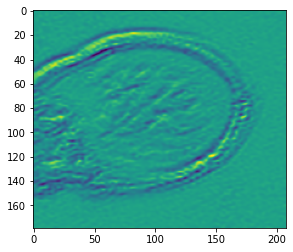

In [171]:
plt.imshow(attention_map)

# RANDOM

In [64]:

# initialize the model
convolutions = {
    'conv0':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':16,
        'd_reduction': "MaxPooling"
    },
    'conv1':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv2':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv3':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':64,
        'd_reduction': "MaxPooling"
    },
    'conv4':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':128,
        'd_reduction': "MaxPooling"
    }
}
model = RandomArchitecture(convolutions,1,data_train.size)


# Define criterion and optimizer
criterion = get_criterion(loss)
optimizer = getattr(torch.optim, optimizer_name)(filter(lambda x: x.requires_grad, model.parameters()),
                                                   lr=learning_rate,
                                                   weight_decay=weight_decay)

In [8]:
class Options:
    def __init__(self):
        self.beginning_epoch = 0
        self.tolerance = 0
        self.patience = 10
        self.epochs = 10
        self.gpu = True
        self.batch_size = 1

In [9]:
train(model, train_loader, valid_loader, criterion, optimizer,False,'log_dir','model_dir', Options())

INFO:root:Beginning epoch 0.


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1625, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1632, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 5

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 566, in __getitem__
    participant, session, cohort, slice_idx, label = self._get_meta_data(idx)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 140, in _get_meta_data
    participant = self.df.loc[image_idx, 'participant_id']
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 889, in __getitem__
    return self._getitem_tuple(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1060, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 807, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1124, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1073, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/generic.py", line 3739, in xs
    loc = index.get_loc(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3082, in get_loc
    raise KeyError(key) from err
KeyError: 5
